In [1]:
# %% [markdown]
# --- Load data ---
# This cell reads the CSVs created by the earlier pipeline.

# %%
from pathlib import Path
import pandas as pd
import numpy as np

DATA_DIR = Path("complexity_outputs")
episodes_df = pd.read_csv(DATA_DIR / "episodes_metrics.csv")
summary_df  = pd.read_csv(DATA_DIR / "podcast_summary.csv", index_col=0)
ranking_df  = pd.read_csv(DATA_DIR / "podcast_complexity_ranking.csv")

print(f"Episodes: {len(episodes_df):,}")
print(f"Podcasts: {len(summary_df):,}")
print("Ranking head:")
display(ranking_df.head())


Episodes: 195
Podcasts: 5
Ranking head:


,podcast,complexity_index
0,RONZHEIMER,0.915466
1,Die_Peter_Thiel_Story,0.361127
2,LANZ_&_PRECHT,0.057693
3,Die_Jägerin,-0.024902
4,Kaulitz_Hills_-_Senf_aus_Hollywood,-1.309384


In [2]:
# %% [markdown]
# --- Helper utilities ---

# %%
import matplotlib.pyplot as plt

def topn(df, col, n=20, ascending=False):
    return df.sort_values(col, ascending=ascending).head(n)

def ensure_cols(df, cols):
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns: {missing}")

# Columns used in visuals / analysis
z_cols = [c for c in summary_df.columns if c.startswith("z_")]
index_col = "complexity_index"
base_feats = [
    "avg_sentence_length_mean",
    "fk_grade_mean",
    "flesch_reading_ease_mean",
    "lexical_density_mean",
    "pos_entropy_mean",
    "avg_dependency_distance_mean",
    "subordination_index_mean",
    "mtld_mean",
    "hdd_mean",
]
ensure_cols(summary_df, [index_col] + z_cols + base_feats)


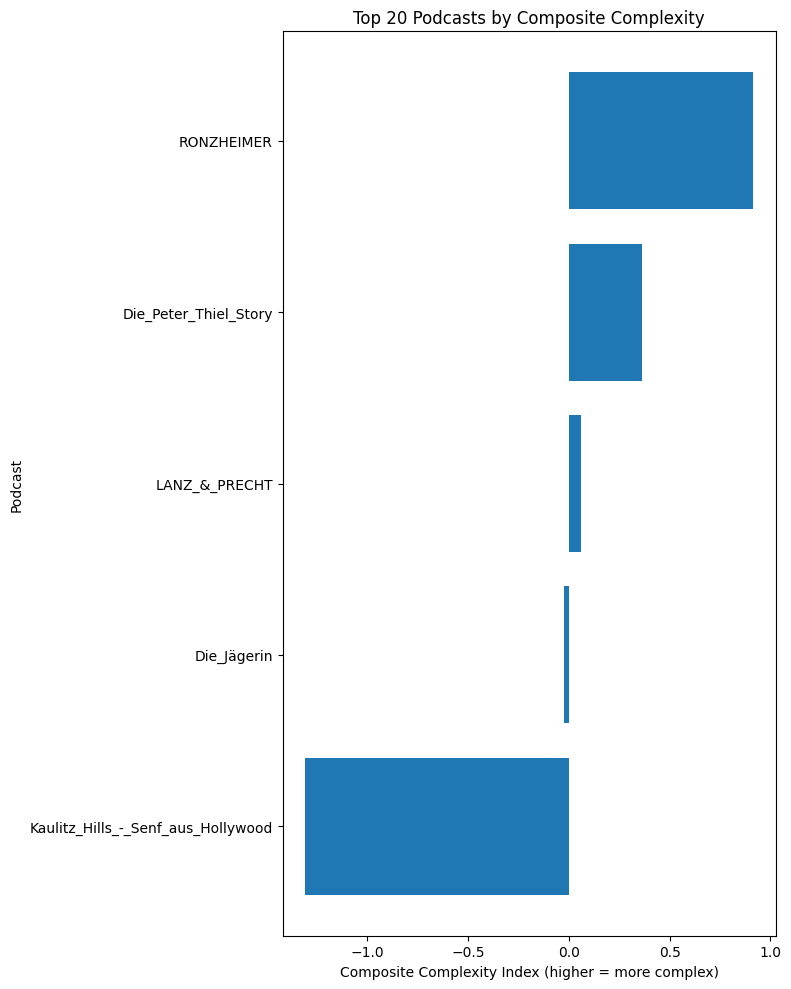

In [3]:
# %% [markdown]
# --- 1) Ranking bar chart: Top 20 podcasts by composite complexity ---

# %%
top20 = ranking_df.sort_values("complexity_index", ascending=False).head(20)
fig, ax = plt.subplots(figsize=(8, 10))
ax.barh(top20["podcast"][::-1], top20["complexity_index"][::-1])
ax.set_xlabel("Composite Complexity Index (higher = more complex)")
ax.set_ylabel("Podcast")
ax.set_title("Top 20 Podcasts by Composite Complexity")
plt.tight_layout()
plt.show()


,corr_with_index
fk_grade_mean,0.918030
pos_entropy_mean,0.822875
mtld_mean,0.778946
avg_sentence_length_mean,0.746205
avg_dependency_distance_mean,0.655778
subordination_index_mean,0.624938
hdd_mean,0.536312
lexical_density_mean,0.523705
flesch_reading_ease_mean,-0.990800


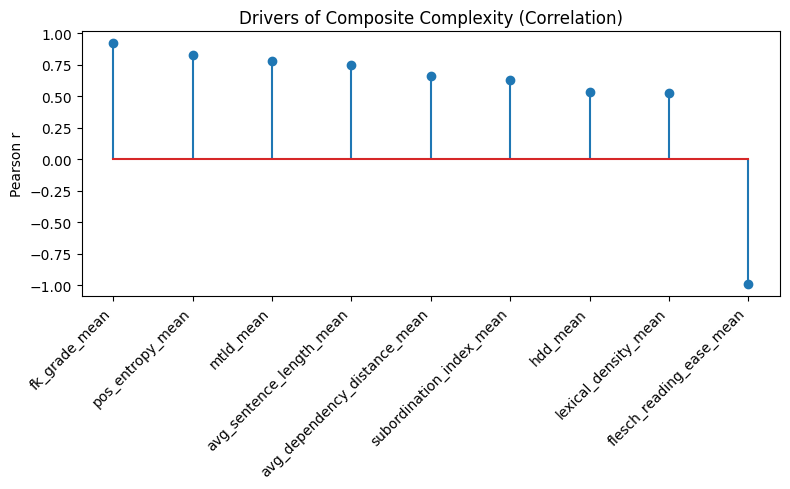

In [5]:
# %% [markdown]
# --- 2) What drives the index? Feature–index correlations ---
# Positive correlation means the feature tends to increase complexity scores.

# %%
# compute Pearson correlations with the composite index
corrs = (
    summary_df[base_feats + [index_col]]
    .corr(numeric_only=True)[index_col]
    .drop(index_col)
    .sort_values(ascending=False)
    .to_frame(name="corr_with_index")
)
display(corrs)

# Simple stem plot for readability
fig, ax = plt.subplots(figsize=(8, 5))
ax.stem(range(len(corrs)), corrs["corr_with_index"].values)
ax.set_xticks(range(len(corrs)))
ax.set_xticklabels(corrs.index, rotation=45, ha="right")
ax.set_ylabel("Pearson r")
ax.set_title("Drivers of Composite Complexity (Correlation)")
plt.tight_layout()
plt.show()


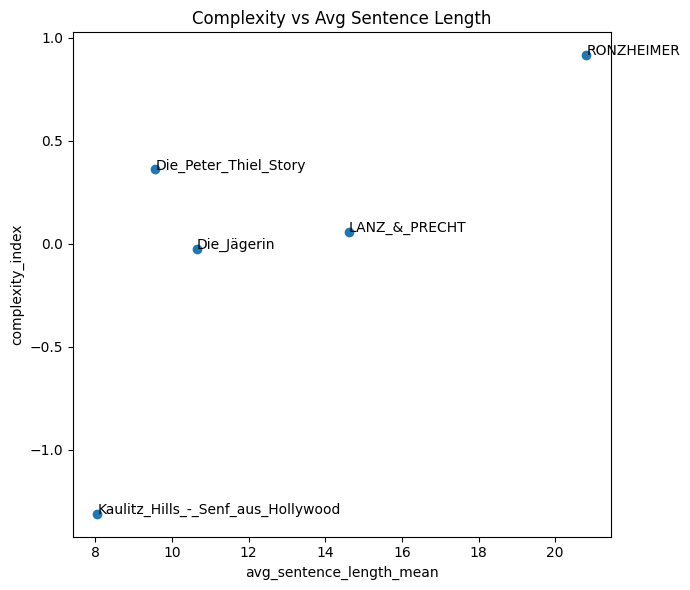

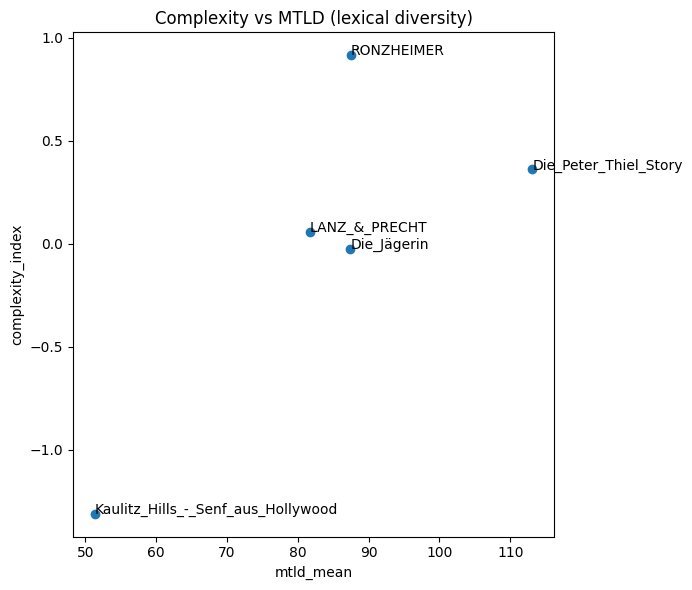

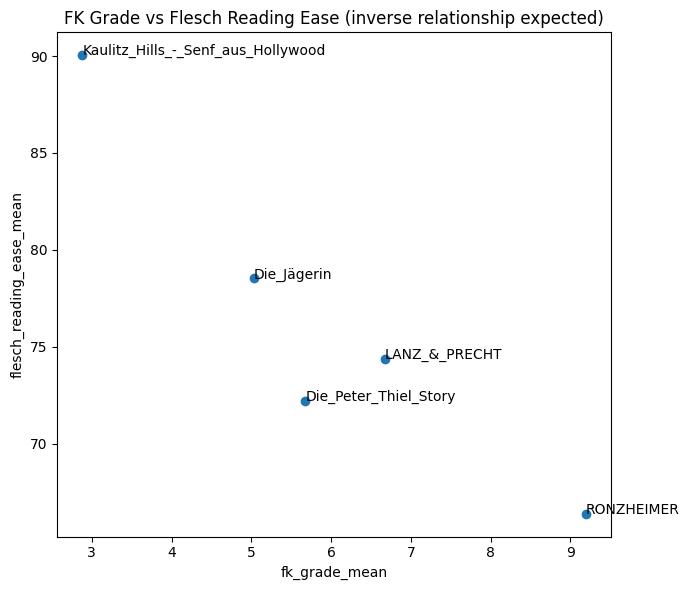

In [6]:
# %% [markdown]
# --- 3) Scatter diagnostics (pairwise) ---
# a) Complexity vs average sentence length
# b) FK grade vs Flesch Reading Ease (sanity check)
# c) Complexity vs MTLD (lexical diversity)

# %%
def scatter_xy(df, x, y, label_col="podcast", annotate=5, figsize=(7,6), title=None):
    fig, ax = plt.subplots(figsize=figsize)
    ax.scatter(df[x], df[y])
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    if title:
        ax.set_title(title)
    # annotate a few most extreme points on y
    if annotate and label_col in df.columns:
        idx = df[y].sort_values(ascending=False).head(annotate).index.tolist()
        for i in idx:
            ax.annotate(str(df.loc[i, label_col]), (df.loc[i, x], df.loc[i, y]))
    plt.tight_layout()
    plt.show()

# merge index back into a frame with features
tmp = summary_df.copy()
tmp["podcast"] = tmp.index

scatter_xy(tmp, "avg_sentence_length_mean", "complexity_index",
           title="Complexity vs Avg Sentence Length")

scatter_xy(tmp, "mtld_mean", "complexity_index",
           title="Complexity vs MTLD (lexical diversity)")

scatter_xy(tmp, "fk_grade_mean", "flesch_reading_ease_mean",
           title="FK Grade vs Flesch Reading Ease (inverse relationship expected)")


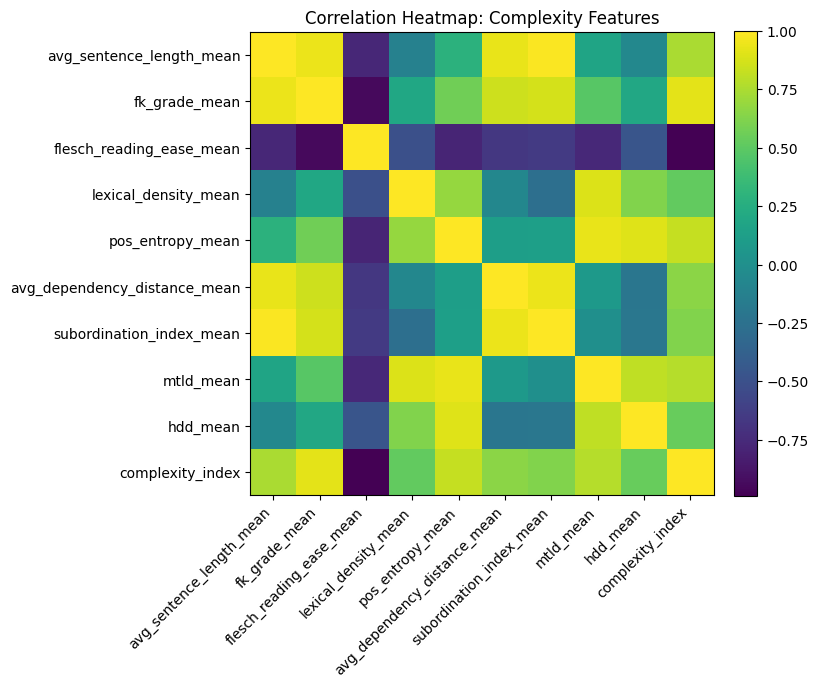

In [7]:
# %% [markdown]
# --- 4) Correlation heatmap across core features + index ---
# (No specific colormap is set; matplotlib defaults are used.)

# %%
heat_cols = base_feats + [index_col]
C = summary_df[heat_cols].corr(numeric_only=True)
fig, ax = plt.subplots(figsize=(8, 7))
im = ax.imshow(C.values, interpolation="nearest")
ax.set_xticks(range(len(heat_cols))); ax.set_xticklabels(heat_cols, rotation=45, ha="right")
ax.set_yticks(range(len(heat_cols))); ax.set_yticklabels(heat_cols)
ax.set_title("Correlation Heatmap: Complexity Features")
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()


Example podcast: RONZHEIMER


,feature,z_value,direction
0,z_avg_dependency_distance_mean,1.981716,high
1,z_subordination_index_mean,1.784285,high
2,z_avg_sentence_length_mean,1.760602,high
3,z_fk_grade_mean,1.597175,high
4,z_flesch_reading_ease_mean,1.254213,high
5,z_flesch_reading_ease_mean,1.254213,low
6,z_pos_entropy_mean,0.176403,low
7,z_mtld_mean,0.167367,low
8,z_lexical_density_mean,-0.020428,low
9,z_hdd_mean,-0.462140,low


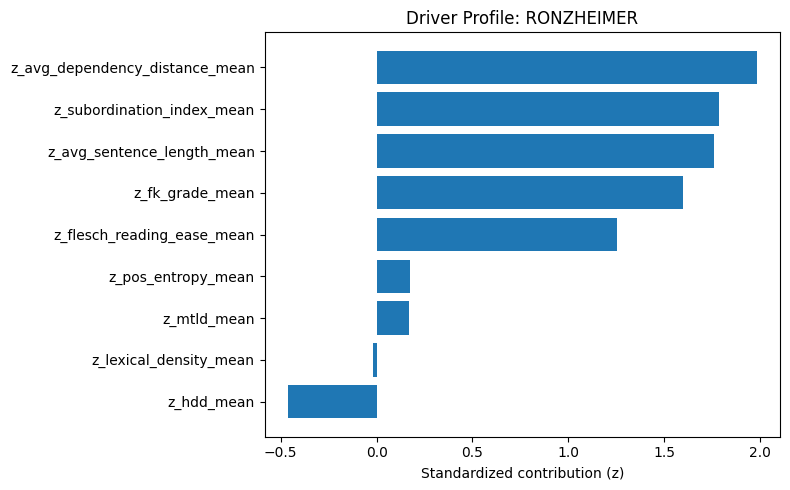

In [8]:
# %% [markdown]
# --- 5) Per-podcast “driver profile” ---
# For any selected podcast, show which standardized (z_) features are highest/lowest.
# Useful to explain *why* a podcast ranks high/low.

# %%
def driver_table(podcast_name, top_k=5):
    if podcast_name not in summary_df.index:
        raise ValueError(f"{podcast_name} not found in podcast_summary.")
    row = summary_df.loc[podcast_name, z_cols].sort_values(ascending=False)
    top_pos = row.head(top_k)
    top_neg = row.tail(top_k)
    out = pd.DataFrame({
        "feature": list(top_pos.index) + list(top_neg.index),
        "z_value": list(top_pos.values) + list(top_neg.values),
        "direction": ["high"]*len(top_pos) + ["low"]*len(top_neg),
    })
    return out

# Example: replace with a podcast from your data
example_podcast = ranking_df.sort_values("complexity_index", ascending=False).iloc[0]["podcast"]
print("Example podcast:", example_podcast)
display(driver_table(example_podcast))

# Bar plot for that profile
def plot_driver_profile(podcast_name, top_k=6):
    prof = driver_table(podcast_name, top_k=top_k)
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.barh(prof["feature"][::-1], prof["z_value"][::-1])
    ax.set_xlabel("Standardized contribution (z)")
    ax.set_title(f"Driver Profile: {podcast_name}")
    plt.tight_layout()
    plt.show()

plot_driver_profile(example_podcast)


In [9]:
# %% [markdown]
# --- 7) Outlier episodes (very complex or very simple) ---
# Identify episodes whose composite *proxies* are extreme relative to their own podcast.

# %%
# Build a simple per-episode proxy complexity score to flag outliers:
# (You can swap in a more elaborate weighting if you like.)
episode_proxy_feats = ["avg_sentence_length","fk_grade","lexical_density","pos_entropy","mtld","hdd"]
ep = episodes_df.dropna(subset=episode_proxy_feats).copy()
# Z-score within the whole corpus:
for c in episode_proxy_feats:
    mu, sd = ep[c].mean(), ep[c].std(ddof=0) or 1
    ep[f"z_{c}"] = (ep[c] - mu) / sd
ep["proxy_complexity"] = ep[[f"z_{c}" for c in episode_proxy_feats]].mean(axis=1)

# Flag top/bottom 15 outliers
out_high = ep.sort_values("proxy_complexity", ascending=False).head(15)
out_low  = ep.sort_values("proxy_complexity", ascending=True).head(15)

print("High-complexity episode candidates:")
display(out_high[["podcast","episode_file","proxy_complexity"] + episode_proxy_feats])

print("Low-complexity episode candidates:")
display(out_low[["podcast","episode_file","proxy_complexity"] + episode_proxy_feats])


High-complexity episode candidates:


,podcast,episode_file,proxy_complexity,avg_sentence_length,fk_grade,lexical_density,pos_entropy,mtld,hdd
76,RONZHEIMER,RONZHEIMER\EIL_Trump-Putin-Gipfel_scheitert!_(...,1.166829,41.986486,17.576146,0.506714,3.500813,77.379920,0.877891
164,RONZHEIMER,RONZHEIMER\Trump_dealt_mit_Putin_&_Iran__Wer_i...,1.106434,31.790909,13.986910,0.515352,3.511107,114.541021,0.890295
166,RONZHEIMER,RONZHEIMER\Trump_gegen_Musk_&_Putin__Neue_AfD-...,1.075413,32.755814,13.833365,0.512357,3.497637,115.153949,0.885681
131,RONZHEIMER,RONZHEIMER\Putins_Angriff_schockt_selbst_Trump...,1.045703,29.522222,13.031671,0.511571,3.515713,120.131410,0.894830
108,RONZHEIMER,"RONZHEIMER\Merz,_Trump_&_der_Krieg_Woche_der_E...",0.988847,31.576687,13.603577,0.514096,3.494150,109.253107,0.882953
178,RONZHEIMER,RONZHEIMER\Warum_Vance_plötzlich_nett(er)_zu_D...,0.862172,25.507614,11.773711,0.517346,3.513753,112.217407,0.896392
81,RONZHEIMER,RONZHEIMER\Geht_Israels_Hamas-Krieg_ewig_weite...,0.823592,32.628713,13.448020,0.507538,3.523206,86.943830,0.875220
67,RONZHEIMER,RONZHEIMER\Breaking_Trump_will_Putin_und_Selen...,0.778459,27.216783,12.083875,0.506587,3.518907,104.936164,0.884995
121,RONZHEIMER,RONZHEIMER\Merz’_Überraschungs-Minister_Jetzt_...,0.740661,32.682464,14.070406,0.499635,3.453491,91.829640,0.869385
180,RONZHEIMER,RONZHEIMER\War_Paul_gar_nicht_in_Israel_Die_Gr...,0.730215,29.988095,12.770390,0.530048,3.430636,88.242674,0.875810


Low-complexity episode candidates:


,podcast,episode_file,proxy_complexity,avg_sentence_length,fk_grade,lexical_density,pos_entropy,mtld,hdd
157,RONZHEIMER,RONZHEIMER\Trumps_Putin-Wende_Die_geheime_Roll...,-3.494762,41.807947,14.788165,0.243162,2.586103,3.722025,0.465411
162,RONZHEIMER,RONZHEIMER\Trump_&_Selenskyj_Verändert_ein_Fot...,-1.131225,52.015504,18.469375,0.812901,2.095522,3.156870,0.376362
29,Kaulitz_Hills_-_Senf_aus_Hollywood,Kaulitz_Hills_-_Senf_aus_Hollywood\Besser_wide...,-1.066869,7.918877,2.650111,0.476156,3.369055,45.762561,0.849824
34,Kaulitz_Hills_-_Senf_aus_Hollywood,Kaulitz_Hills_-_Senf_aus_Hollywood\Chill_Deine...,-1.059604,7.421573,2.416071,0.486724,3.344118,47.234764,0.849823
26,Kaulitz_Hills_-_Senf_aus_Hollywood,Kaulitz_Hills_-_Senf_aus_Hollywood\Anstandsfck...,-1.048486,8.218370,2.698639,0.487483,3.318986,49.861683,0.846476
30,Kaulitz_Hills_-_Senf_aus_Hollywood,Kaulitz_Hills_-_Senf_aus_Hollywood\Besser_wird...,-1.021221,7.588368,2.501602,0.479198,3.366083,48.429634,0.858640
40,Kaulitz_Hills_-_Senf_aus_Hollywood,Kaulitz_Hills_-_Senf_aus_Hollywood\Den_Wiener_...,-1.020273,7.607396,2.807377,0.483101,3.359640,46.443171,0.854859
5,Die_Jägerin,Die_Jägerin\Trailer_Die_Jägerin.txt,-1.004962,8.207547,3.454954,0.459397,3.439043,49.968034,0.842503
18,Kaulitz_Hills_-_Senf_aus_Hollywood,Kaulitz_Hills_-_Senf_aus_Hollywood\5_Tage_wach...,-0.984078,7.960079,2.863079,0.483722,3.382645,45.362696,0.854658
17,Kaulitz_Hills_-_Senf_aus_Hollywood,Kaulitz_Hills_-_Senf_aus_Hollywood\3er_mit_Xav...,-0.974272,8.161823,2.631953,0.486326,3.358995,49.254306,0.856954
